In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY, STATE_ORDER

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS


def _preprocess(replay_info):
    N_UNIQUE_SPIKING = 2
    replay_info = replay_info.set_index(
        ["animal", "day", "epoch", "ripple_number"]
    ).rename_axis(index={"animal": "Animal ID"})
    replay_info = replay_info.loc[
        replay_info.n_unique_spiking >= N_UNIQUE_SPIKING
    ].sort_index()
    return replay_info


def load_replay_info(epoch_key):
    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"

    file_path = os.path.join(
        PROCESSED_DATA_DIR,
        f"{animal}_{day:02d}_{epoch:02}_{data_type}_{dim}_replay_info.csv",
    )
    return _preprocess(pd.read_csv(file_path))


def load_shuffle_replay_info(epoch_key):
    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"

    file_paths = glob(
        os.path.join(
            PROCESSED_DATA_DIR,
            "shuffle",
            f"{animal}_{day:02d}_{epoch:02}_{data_type}_{dim}_replay_info_shuffle_*.csv",
        )
    )
    return [_preprocess(pd.read_csv(file_path)) for file_path in file_paths]

In [4]:
def get_percent_classified(replay_info):
    return replay_info["is_classified"].mean() * 100

In [5]:
def plot_is_classified(epoch_key, ax):
    replay_info = load_replay_info(epoch_key)
    shuffle_replay_infos = load_shuffle_replay_info(epoch_key)

    is_classified = np.asarray([get_percent_classified(replay_info)])
    shuffle_is_classified = np.asarray(
        [
            get_percent_classified(shuffle_replay_info)
            for shuffle_replay_info in shuffle_replay_infos
        ]
    )

    sns.distplot(shuffle_is_classified, color="lightgrey", ax=ax)
    ax.axvline(is_classified, color="red")
    ax.set_xlim((-1, 102))
    ax.set_xticks((0, 100))
    ax.set_xticklabels((0, 100))
    ax.set_xlabel("Percent Classified")
    animal, day, epoch = epoch_key
    sns.despine(left=True)

    N_SHUFFLES = 50
    print(epoch_key)
    print(f"n_ripples = {replay_info.shape[0]}")
    print(f"median shuffle classified = {np.median(shuffle_is_classified):.0f}")
    print(f"median classified = {is_classified[0]:.0f}")
    print(
        f"p-value = {(np.sum(is_classified <= shuffle_is_classified) + 1) / (N_SHUFFLES + 1):0.2f}"
    )
    print("\n")

('bon', 3, 2)
n_ripples = 251
median shuffle classified = 9
median classified = 99
p-value = 0.02


('remy', 35, 2)
n_ripples = 344
median shuffle classified = 14
median classified = 97
p-value = 0.02




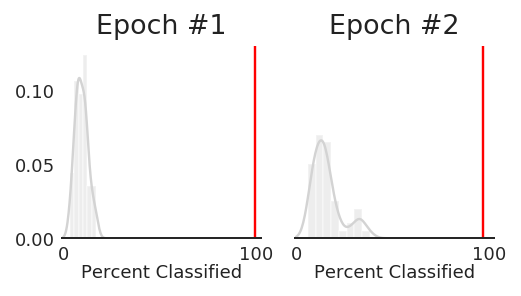

In [6]:
fig, axes = plt.subplots(
    1, 2, figsize=(ONE_COLUMN, PAGE_HEIGHT / 5), constrained_layout=True, sharey=True,
)
epoch_keys = [("bon", 3, 2), ("remy", 35, 2)]

for epoch_ind, (ax, epoch_key) in enumerate(zip(axes.flat, epoch_keys)):
    plot_is_classified(epoch_key, ax)
    ax.set_title(f"Epoch #{epoch_ind + 1}")

save_figure(
    os.path.join("Figure3-supplemental2", "figure3-supplemental2_is_classified")
)